# Training and smoothing a function using a quantum neural network

Author: Mack

This is a modified implementation of Maria Schuld's original tutorial featuring a noisy sine wave as the training data. A _variational circuit_ is used to learn a one-dimensional real-valued function when being trained with a small or noisy sample. The variational circuit used is the continuous variable quantum neural network model, described by [Killoran et al. (2018)](https://arxiv.org/abs/1806.06871). The variational circuit we will use is described by [this blog](https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/) by Catalina Albornoz.

In [2]:
# Libraries

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Generating the function

Noise is added to simulate datapoints that follow a sinusoidal relation.

In [5]:
X_noise = 0.01
Y_noise = 0.1

# Randomly generate the training data
X = np.linspace(0, 7, 155)
X += (2*X_noise*np.random.random(len(X)) - X_noise)
X.requires_grad = False # Becomes input for run_iterations

# Add noise to the training label
Y = np.sin(X) + (2*Y_noise*np.random.random(len(X)) - Y_noise)

# Generate test data using conventional functions
X_test = np.linspace(-2*np.pi, 4*np.pi, 36)
Y_test = np.sin(X_test)

## Graphing the function

Biue dots are inexact datapoints used for training. Black dots are approximately exact datapoints for testing.

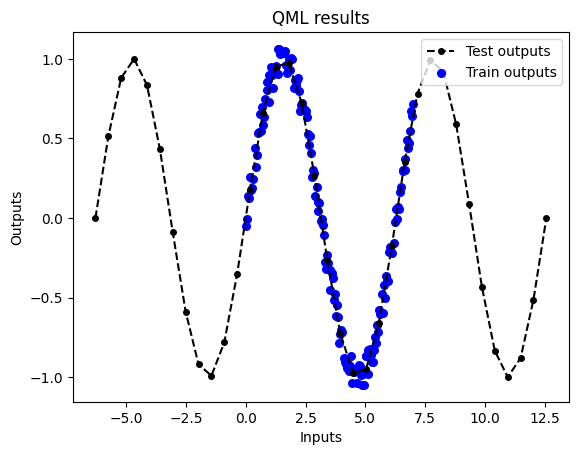

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(X_test,Y_test, 'ko--', markersize=4, label='Test outputs')
ax1.scatter(X, Y, s=30, c='b', marker="o", label='Train outputs')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

## Fitting the sine wave

A _single-qubit variational circuit_ can be used to fit the sine wave, leveraging the trigonometric nature of the RX gate.

In [7]:
# Create device and quantum circuit
dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def qcircuit(datapoint, params):
    # Prepare datapoints the corresponding RX gate
    qml.RX(datapoint, wires=0)
    # All unitary gates can be decomposed into three 
    qml.Rot(params[0], params[1], params[2], wires=0)
    # Return expectation of measurement along the Z-axis
    return qml.expval(qml.PauliZ(wires=0))

## Running iterations

With a training set and validation/test set, we develop a function that calls the quantum circuit, and returns the total cost given the parameters.

In [15]:
# Declare loss function
def loss(prediction):
    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

# Perform run, and calculate cost. No call of the sine function is used there.
def cost_fn(params):
    prediction = [qcircuit(x, params) for x in X]
    cost = loss(prediction)
    return cost

## Driver code

An optimizer is chose, with a learning rate, to minimize the cost using gradient descent. The ansatz parameters are three random principal angles.

In [20]:
# Declare loss function
def loss(predictions):
    total_losses = 0
    for i in range(len(Y_train)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

# Perform run, and calculate cost. No call of the sine function is used there.
def run_iteration():
    prediction = [qcircuit(x, params) for x in X_train]
    cost = loss(prediction)
    return cost 
    
# Define optimizer and ansatz paraneters
opt = qml.GradientDescentOptimizer(stepsize=0.05)
params = np.array(np.random.random(3)*2*np.pi,requires_grad=True)
ITERATION = 100

# Step 5.4 - We iterate over a number of defined steps (100)
cost_hist = []
for i in range (ITERATION):
    params, prev_cost = opt.step_and_cost(cost_fn, params)
    cost_hist.append(prev_cost)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {prev_cost}')

Step = 0 Cost = 90.71871187551001
Step = 10 Cost = 104.9150255363969
Step = 20 Cost = 152.11721655389752
Step = 30 Cost = 63.52661590948251
Step = 40 Cost = 62.975347995479005
Step = 50 Cost = 63.080839734583776
Step = 60 Cost = 63.058998448118366
Step = 70 Cost = 63.06346543152306
Step = 80 Cost = 63.06254941488948
Step = 90 Cost = 63.062737155711446


## Graphing the results

We graph both the sine wave regression line, and the history of the training.

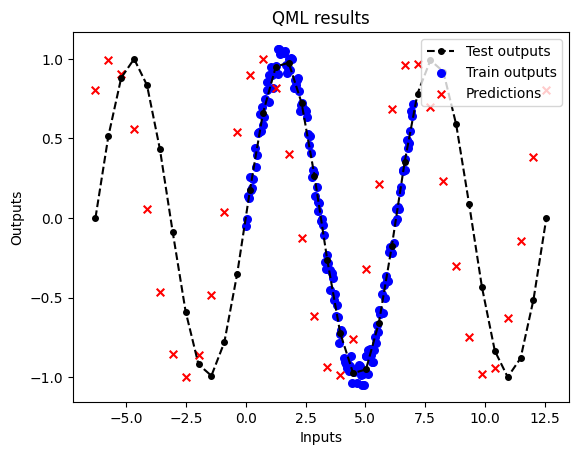

In [24]:
# Test and graph the predictions
test_predictions = []
for x in X_test:
    prediction = qcircuit(x,params)
    test_predictions.append(prediction)

# Graph again
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(X_test,Y_test, 'ko--', markersize=4, label='Test outputs')
ax1.scatter(X, Y, s=30, c='b', marker="o", label='Train outputs')
ax1.scatter(X_test, test_predictions, s=30, c='r', marker="x", label='Predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

# Discussion

Trigonometry is central to the study of quantum mechanics, so it is natural to consider fitting a trigonometric graph with a single quantum circuit. Can you do this for transformed trigonometric graphs? And can you try fitting a trigonometric sine function in terms of a differential equation?